In [18]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import PIL
import scipy.optimize
import numba

In [19]:
class Ellipse:
    error = 1e-5 # np.finfo(float).eps
    
    def __init__(self, a: np.ndarray, b: np.ndarray, c: float):
        self.C = np.mean([a,b], axis=0)
        
        diff = b-a
        len_diff = np.linalg.norm(diff)
        if len_diff > 0.0:
            if len_diff > c:
                raise Exception()
            
            self.U0 = diff/len_diff
            self.U1 = np.array([[0., -1.], [1., 0.]]) @ self.U0
            
            self.e0 = np.abs(c/2)
            self.e1 = np.sqrt( (c/2)**2 - (len_diff/2)**2)
        else:
            self.U0 = np.array([1., 0.])
            self.U1 = np.array([0., 1.])
            
            self.e0 = self.e1 = np.abs(c/2)

        if self.e1 > self.e0: # swap
            h = self.e0
            self.e0 = self.e1
            self.e1 = h

            h_vec = self.U0
            self.U0 = self.U1
            self.U1 = h_vec
            
        self.e = np.array([self.e0, self.e1])
        self.R = np.array([self.U0, self.U1]).T
        self.M = self.R @ np.diag([1/self.e0**2, 1/self.e1**2]) @ self.R.T

            
    def x(self, y, t):
        return self.e**2 *y/(self.e**2+t)
    
    def F(self, y: np.ndarray, t: float):
        return np.sum((self.e*y/(self.e**2+t))**2) - 1.0

    def foo(self, q: np.ndarray):
        y = np.abs(self.R.T @ (q-self.C))
        # print(y)

        if y[1] > 0:
            if y[0] > 0:

                # compute root
                neg_e1_sq = -self.e1**2
                t0 = neg_e1_sq + y[1]*self.e1 
                t1 = neg_e1_sq + np.linalg.norm(y*self.e)
                
                # bisecting algorithm
                # print(t0, t1)
                # print(self.F(y, t0), self.F(y, t1))

                f = lambda h: self.F(y, h)

                t = scipy.optimize.bisect(f, t0, t1, rtol=0.0001)
                x = self.x(y, t)
                dist = np.linalg.norm(x-y)

            else:
                dist = np.abs(y[1] - self.e1)
                    
        else:
            e_sq = self.e**2
            if y[0] < (e_sq[0] - e_sq[1])/self.e0:
                x0 = e_sq[0]*y[0] / (e_sq[0] - e_sq[1])
                x1_sq = e_sq[1]*(1 - (x0**2/e_sq[0]))
                # print(x0)
                # print(x1_sq)
                # print((x0 - y[0])**2 + x1_sq)
                dist =  np.sqrt((x0 - y[0])**2 + x1_sq)
            else:
                dist = np.abs(y[0]- self.e0)

        
        return dist*np.sign(np.linalg.norm(y/self.e) - 1.0)

        
        

In [20]:
a = np.array([0., 0.])
b = np.array([ 33., 38.])
E = Ellipse(a,b, 100.0)

In [21]:
E.foo(np.array([1.,0.0]))

-25.465990527766625

In [22]:
im = np.empty([100,100])

In [23]:
dim_x, dim_y = im.shape

for i in range(dim_x):
    for j in range(dim_y):
        im[j,i] = E.foo(np.array([j,i], dtype=float))

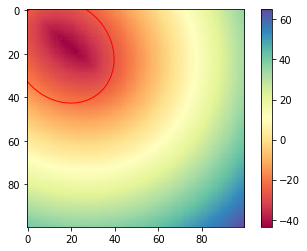

In [24]:
import matplotlib.patches

fig, ax = plt.subplots(subplot_kw={'aspect': 'equal'})
i = ax.imshow(im, cmap='Spectral')
fig.colorbar(i)
ellipse = matplotlib.patches.Ellipse(E.C, E.e0, E.e1, np.angle(E.U0[0]+E.U0[1]*1j , deg=True), linewidth=1, linestyle='-', edgecolor='red', fill=False)
ax.add_artist(ellipse)

In [25]:
def gaussian(x, mu, sig):
    return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))/(np.sqrt(2.*np.pi)*sig)

In [26]:
im2 = gaussian(im, 0.0, 2.0)

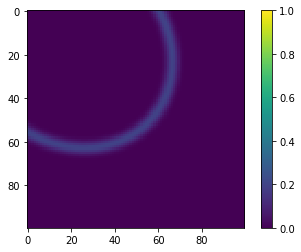

In [27]:
fig, ax = plt.subplots(subplot_kw={'aspect': 'equal'})
i = ax.imshow(im2)
i.set_clim(0, 1.0)
fig.colorbar(i )


# Second Try

In [28]:
from abc import ABC, abstractmethod

class Kernel(ABC):

    @abstractmethod
    def get_val(self, t: np.ndarray) -> np.ndarray:
        raise NotImplementedError

    @abstractmethod
    def get_width(self) -> float:
        raise NotImplementedError

class GaussKernel(Kernel):
    def __init__(self, sigma: float):
        self.sigma = sigma

    def get_val(self, t: np.ndarray) -> np.ndarray:
        return np.exp(-(t/self.sigma)**2)

    def get_width(self) -> float:
        prec = 1e-20
        return np.sqrt(-np.log(prec))*self.sigma



In [29]:

def get_A(d, t):
    return np.pi/6*t*(t**2-d**2)

def get_A_2D(d, t):
    return np.pi/4*t*np.sqrt(t**2-d**2)

def get_c(h, a, b, T, kernel: Kernel):
    c_array = T.copy()

    d = np.linalg.norm(a-b)
    w = kernel.get_width()

    for i in range(len(T)):
        arr = np.arange(start=max(d,T[i]-w), stop=T[i]+w, step=h) # Shape: [N]
        c_array[i] = np.sum(kernel.get_val(arr-T[i])*(get_A_2D(d, arr+h) - get_A_2D(d, arr)), axis=0)

    return c_array

def get_t(a, b, T, pos):
    """
    pos.shape: [3,X*Y*Z]
    T.shape: [NUM_T]
    """
    rep_pos = np.repeat(pos[:, np.newaxis, :], len(T), axis=1) # Shape: [3,NUM_T,X*Y*Z]
    return np.linalg.norm(rep_pos - a[:, np.newaxis, np.newaxis], axis=0) + np.linalg.norm(rep_pos - b[:, np.newaxis, np.newaxis], axis=0) - T[np.newaxis, :,np.newaxis]

def get_grid(res_x, res_y, res_z, dtype=np.float32):
    d = np.zeros([3, res_x, res_y, res_z], dtype=dtype)
    d[0,:,:] = np.arange(0., stop=res_x, step=1.)[:, np.newaxis, np.newaxis]
    d[1,:,:] = np.arange(0., stop=res_y, step=1.)[np.newaxis, :, np.newaxis]
    d[2,:,:] = np.arange(0., stop=res_z, step=1.)[np.newaxis, np.newaxis, :]
    return d

def k_gauss(sigma):
    return lambda t: np.exp(-(t/sigma)**2)

def get_f(pos, a, b, T, kernel, h):
    """
    pos.shape: [3,X,Y,Z]

    T.shape: [NUM_T]

    res.shape: [NUM_T,X,Y,Z]
    """
    pos_shape = grid.shape[1:]

    t = get_t(a, b, T, pos.reshape([3,-1])) # Shape: [1, NUM_T, X*Y*Z]
    #TODO: calculate c
    c = get_c(h, a, b, T, kernel)[np.newaxis, :, np.newaxis]
    f: np.ndarray = kernel.get_val(t)/c
    return f.reshape([len(T), *pos_shape])


In [45]:
a = np.array([20., 20., 0])
b = np.array([ 45., 45., 0])
T = 48
sigma = 2

r = 1

grid = get_grid(r*100, r*100, 100)
# grid_shape = grid.shape[1:]

# t = get_t(r*a,r*b, r*88, grid.reshape([2,-1]))
# f = k_gauss(t, r*sigma).reshape(grid_shape)

f = get_f(grid, r*a, r*b, r*np.linspace(0.0, 120.0, num=40)+np.linalg.norm(a-b), GaussKernel(r*sigma), 0.1)
print(f.shape)


(40, 100, 100, 100)


1.1125796102456984
78125.0 kiB


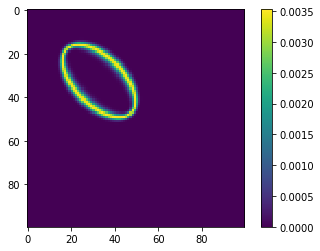

In [31]:
print(np.sum(f[5,:,:,11])/r**2)
print(np.size(f)*4/1024, 'kiB')

plt.imshow(f[2,:,:,0])
plt.colorbar()

In [32]:
from skimage.measure import block_reduce

In [33]:
# f_reduced = block_reduce(f, (r,r), func=np.mean)

In [34]:
# plt.imshow(f_reduced)

NameError: name 'f_reduced' is not defined

In [37]:
from ipywidgets.widgets import * 
import ipywidgets as widgets

# slide through dicom images using a slide bar 
plt.figure(1)
def dicom_animation(T,z):
    plt.imshow(f[T,:,:,z])
interact(dicom_animation, T=(0, f.shape[0]-1), z=(0,f.shape[3]-1))

<Figure size 432x288 with 0 Axes>

interactive(children=(IntSlider(value=9, description='T', max=19), IntSlider(value=49, description='z', max=99…

<function __main__.dicom_animation(T, z)>

In [38]:
%timeit f[0,:,:,0]@f[1,:,:,0]

1.94 ms ± 69.9 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)



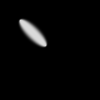
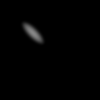
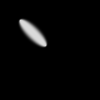
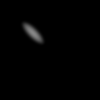
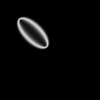
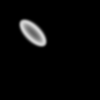
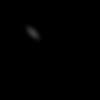
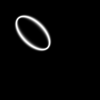
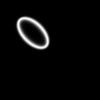
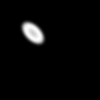
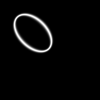
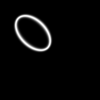
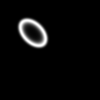
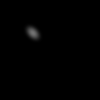
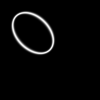
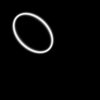
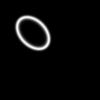
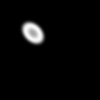
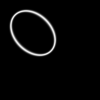
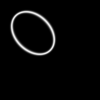
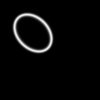
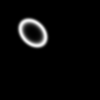
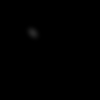
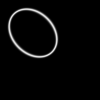
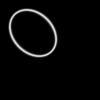
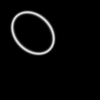
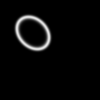
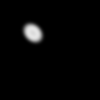
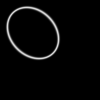
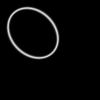
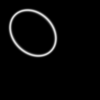
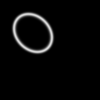
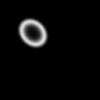
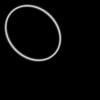
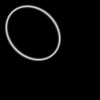
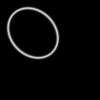
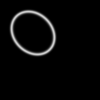
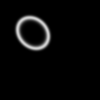
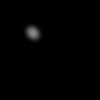
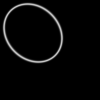
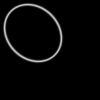
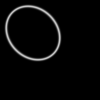
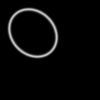
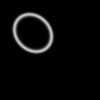
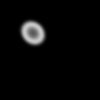
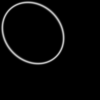
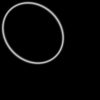
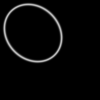
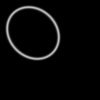
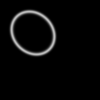
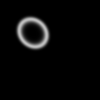
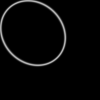
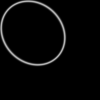
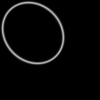
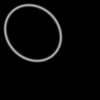
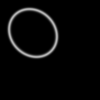
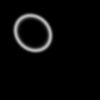
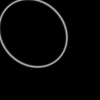
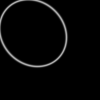
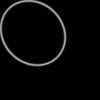
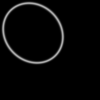
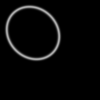
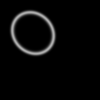
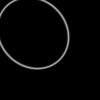
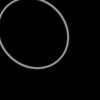
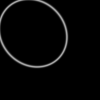
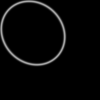
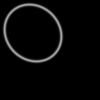
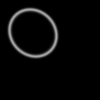
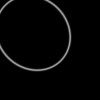
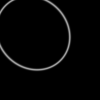
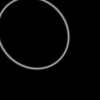
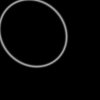
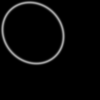
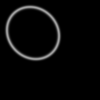
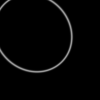
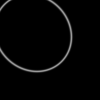
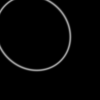
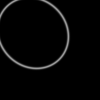
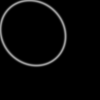
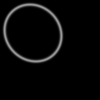
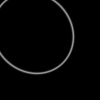
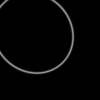
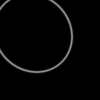
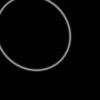
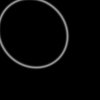
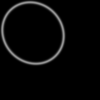
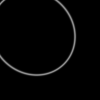
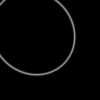
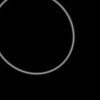
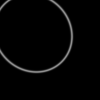
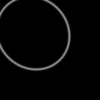
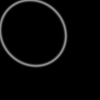
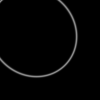
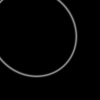
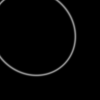
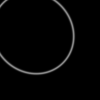
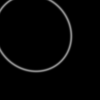
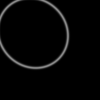
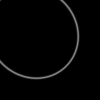
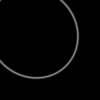
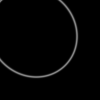
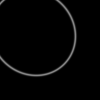
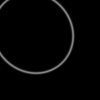
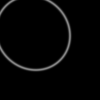
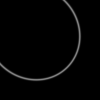
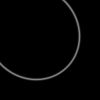
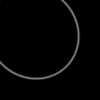
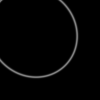
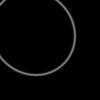
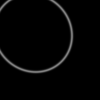
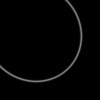
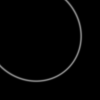
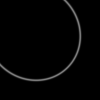
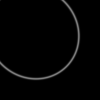
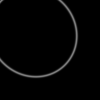
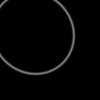
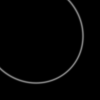
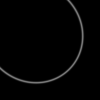
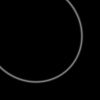
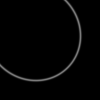
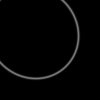
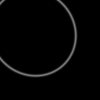
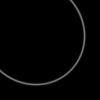
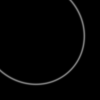
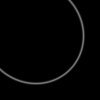
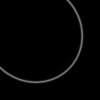
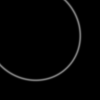
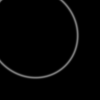
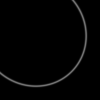
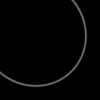
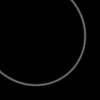
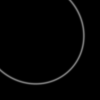
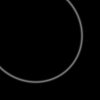
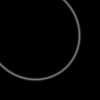
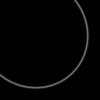
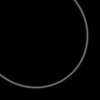
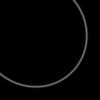
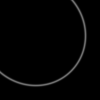
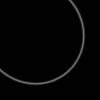
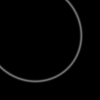
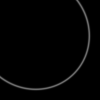
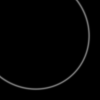
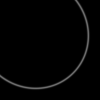
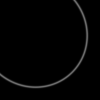
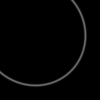
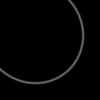
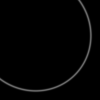
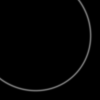
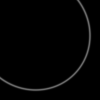
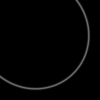
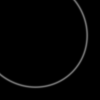
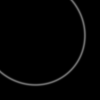
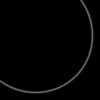
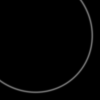
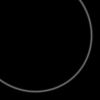
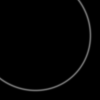
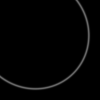
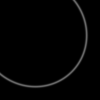
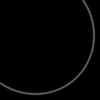
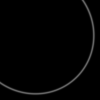
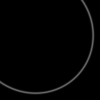
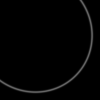
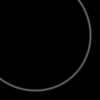
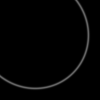
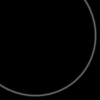
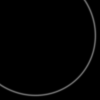
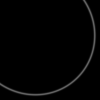
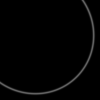
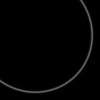
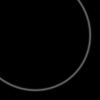
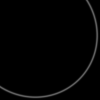
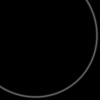
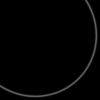
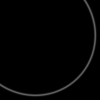
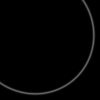
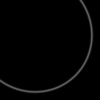
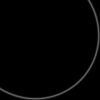
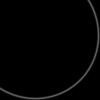
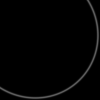
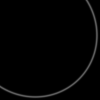
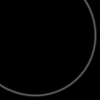
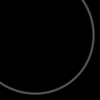
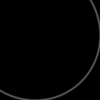
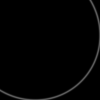
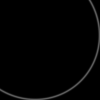
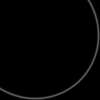
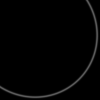
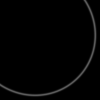
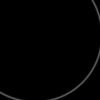
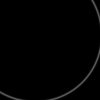
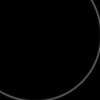
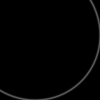
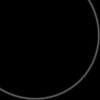
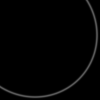
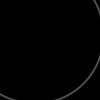
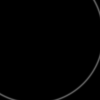
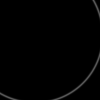
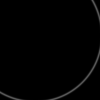
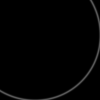
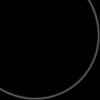
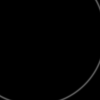
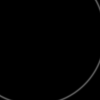
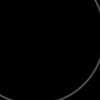
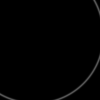
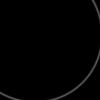
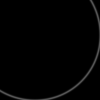
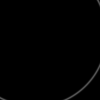
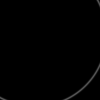
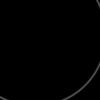
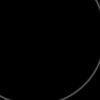
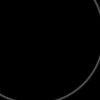
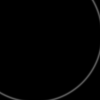
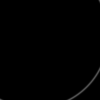
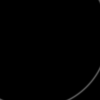
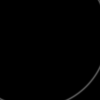
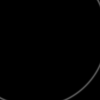
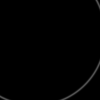
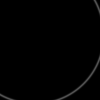
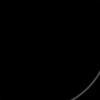
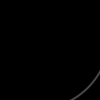
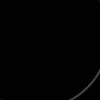
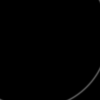
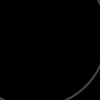
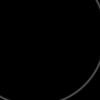

In [47]:
import plotly.express as px
from skimage import io
# data = io.imread("https://github.com/scikit-image/skimage-tutorials/raw/main/images/cells.tif")
img = f[:,:,:,0:30:5]
fig = px.imshow(img, animation_frame=0, facet_col=3, binary_string=True, labels=dict(animation_frame="slice"))
fig.show()